# 3D Shape Classification with Sublevelset Filtrations

In this module, we will explore how TDA can be used to classify 3D shapes.  We will begine by clustering triangle meshes of humans in different poses by pose.  We will then explore how to cluster a collection of shapes which are undergoing nonrigid transformations, or "articulations."

As always, let's first import all of the necessary libraries.

In [1]:
import numpy as np
%matplotlib notebook
import scipy.io as sio
from scipy import sparse 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys 
sys.path.append("pyhks")
from HKS import *
from GeomUtils import *
from ripser import ripser
from persim import plot_diagrams, wasserstein
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

Now, let's include some code that performs a sublevelset filtration by some scalar function on the vertices of a triangle mesh.

In [2]:
def do0DSublevelsetFiltrationMesh(VPos, ITris, fn):
    x = fn(VPos, ITris)
    N = VPos.shape[0]
    # Add edges between adjacent points in the mesh    
    I, J = getEdges(VPos, ITris)
    V = np.maximum(x[I], x[J])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    return ripser(D, distance_matrix=True, maxdim=0)['dgms'][0]

Let's also define a function which will plot a particular scalar function on XY and XZ slices of the mesh

In [3]:
def plotPCfn(VPos, fn, cmap = 'afmhot'):
    """
    plot an XY slice of a mesh with the scalar function used in a 
    sublevelset filtration
    """
    x = fn - np.min(fn)
    x = x/np.max(x)
    c = plt.get_cmap(cmap)
    C = c(np.array(np.round(x*255.0), dtype=np.int64))
    plt.scatter(VPos[:, 0], VPos[:, 1], 10, c=C)
    plt.axis('equal')
    ax = plt.gca()
    ax.set_facecolor((0.3, 0.3, 0.3))

# Experiment 1: Clustering of Human Poses

In the first experiment, we will load surfaces of 10 different people, each performing one of 10 different poses, for 100 total.  To classify by pose, we will use the height function as our sublevelset function.  Let's load a few examples to see what they look like.  The code below loads in all of the triangle meshes in the "shapes" directory

#### Questions
* After looking at some examples, why would filtering by height be a good idea for picking up on these poses?



<IPython.core.display.Javascript object>


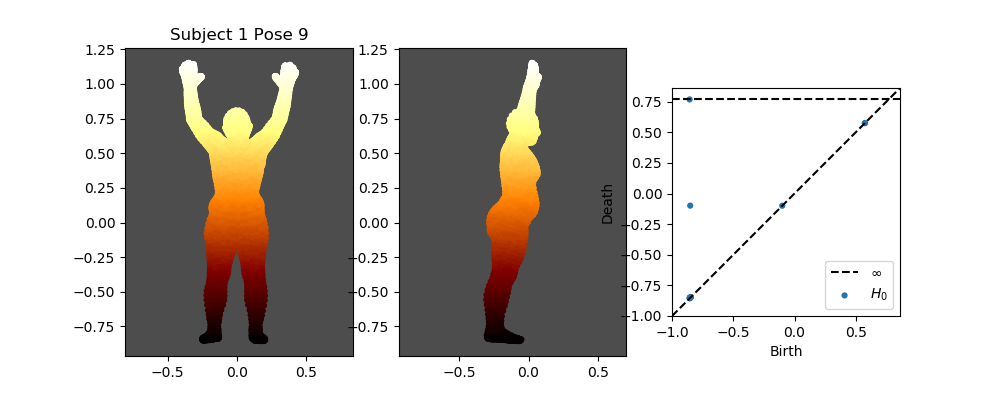

In [4]:
subjectNum = 1
poseNum = 9
i = subjectNum*10 + poseNum

fn = lambda VPos, ITris: VPos[:, 1] #Return the y coordinate as a function

(VPos, _, ITris) = loadOffFile("shapes/tr_reg_%.03d.off"%i)

x = fn(VPos, ITris)
I = do0DSublevelsetFiltrationMesh(VPos, ITris, fn)
plt.figure(figsize=(10, 4))
plt.subplot(131)
plotPCfn(VPos, x, cmap = 'afmhot')
plt.title("Subject %i Pose %i"%(subjectNum, poseNum))
plt.subplot(132)
plotPCfn(VPos[:, [2, 1, 0]], x, cmap = 'afmhot')
plt.subplot(133)
plot_diagrams([I])
plt.show()

Now let's load in all of the meshes and sort them so that contiguous groups of 10 meshes are the same pose (by default they are sorted by subject).

In [5]:
meshes = []
for poseNum in range(10):
    for subjectNum in range(10):
        i = subjectNum*10 + poseNum
        VPos, _, ITris = loadOffFile("shapes/tr_reg_%.03d.off"%i)
        meshes.append((VPos, ITris))

Finally, we compute the 0D sublevelset filtration on all of the shapes, followed by a Wasserstein distance computation between all pairs to examine how different shapes cluster together.  We also display the result of 3D multidimensional scaling using the matrix of all pairs of Wasserstein distances.

#### Questions
* Look at the pairwise Wasserstein distances and the corresponding 3D MDS plot.  Which pose classes are similar to each other by our metric?  Can you go back above and pull out example poses from different subjects that show why this might be the case?

Computing persistence diagrams...
Comparing pose 0...
Comparing pose 1...
Comparing pose 2...
Comparing pose 3...
Comparing pose 4...
Comparing pose 5...
Comparing pose 6...
Comparing pose 7...
Comparing pose 8...
Comparing pose 9...


<IPython.core.display.Javascript object>


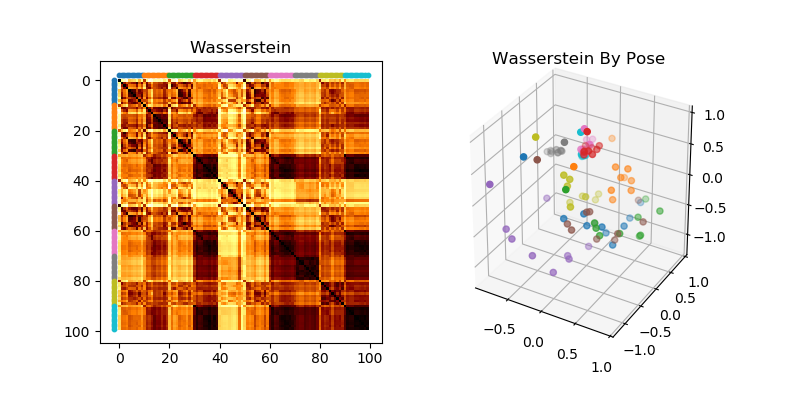

In [6]:
dgms = []
N = len(meshes)
print("Computing persistence diagrams...")
for i, (VPos, ITris) in enumerate(meshes):
    x = fn(VPos, ITris)
    I = do0DSublevelsetFiltrationMesh(VPos, ITris, fn)
    I = I[np.isfinite(I[:, 1]), :]
    dgms.append(I)

# Compute Wasserstein distances in order of pose
DWass = np.zeros((N, N))
for i in range(N):
    if i%10 == 0:
        print("Comparing pose %i..."%(i/10))
    for j in range(i+1, N):
        DWass[i, j] = wasserstein(dgms[i], dgms[j])
DWass = DWass + DWass.T
# Re-sort by class

# Now do MDS and PCA, respectively
mds = MDS(n_components=3, dissimilarity='precomputed')
mds.fit_transform(DWass)
XWass = mds.embedding_

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(DWass, cmap = 'afmhot', interpolation = 'none')
plt.title("Wasserstein")
ax1 = plt.gca()

ax2 = plt.subplot(122, projection='3d')
ax2.set_title("Wasserstein By Pose")
for i in range(10):
    X = XWass[i*10:(i+1)*10, :]
    ax2.scatter(X[:, 0], X[:, 1], X[:, 2])
    Is = (i*10 + np.arange(10)).tolist() + (-2*np.ones(10)).tolist()
    Js = (-2*np.ones(10)).tolist() + (i*10 + np.arange(10)).tolist()
    ax1.scatter(Is, Js, 10)
plt.show()

# Experiment 2: Clustering of Nonrigid Shapes

In this experiment, we will use a different sublevelset which is blind to <i>intrinsic isometries</i>.  This can be used to cluster shapes in a way which is invariant to articulated poses, which is complementary to the previous approach.  As our scalar function will use the "heat kernel signature," which is a numerically stable way to compute curvature at multiple scales.  We will actually negate this signature, since we care more about local maxes than local mins in the scalar function.  So sublevelsets will start at regions of high curvature.

Let's explore a few examples below in a dataset which is a subset of the McGill 3D Shape Benchmark with 10 shapes in 10 different articulations.  In particular, we will load all of the shapes from the "shapes_nonrigid" folder within the TDALabs folder. Run the code and change the "classNum" and "articulationNum" variables to explore different shapes

#### Questions
* Does it seem like the persistence diagrams stay mostly the same within each class?  If so, why?

<IPython.core.display.Javascript object>


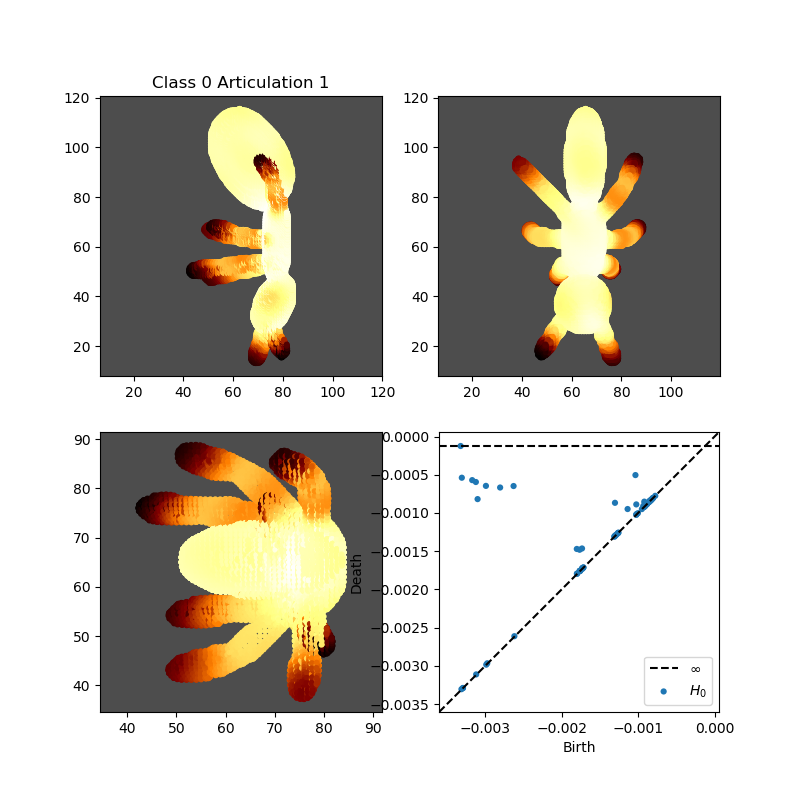

In [7]:
classNum = 0
articulationNum = 1
classes = ['ant', 'hand', 'human', 'octopus', 'pliers', 'snake', 'shark', 'bear', 'chair']

i = classNum*10 + articulationNum

fn = lambda VPos, ITris: -getHKS(VPos, ITris, 20, t = 30)

(VPos, _, ITris) = loadOffFile("shapes_nonrigid/%.3d.off"%i)

x = fn(VPos, ITris)
I = do0DSublevelsetFiltrationMesh(VPos, ITris, fn)
plt.figure(figsize=(8, 8))
plt.subplot(221)
plotPCfn(VPos, x, cmap = 'afmhot')
plt.title("Class %i Articulation %i"%(classNum, articulationNum))
plt.subplot(222)
plotPCfn(VPos[:, [2, 1, 0]], x, cmap = 'afmhot')
plt.subplot(223)
plotPCfn(VPos[:, [0, 2, 1]], x, cmap = 'afmhot')
plt.subplot(224)
plot_diagrams([I])
plt.show()

Let's now load in a few of the nonrigid meshes and compute the sublevelset function of their heat kernel signatures

In [8]:
N = 90
meshesNonrigid = []
for i in range(N):
    (VPos, _, ITris) = loadOffFile("shapes_nonrigid/%.3d.off"%i)
    meshesNonrigid.append((VPos, ITris))

In [9]:
dgmsNonrigid = []
N = len(meshesNonrigid)
print("Computing persistence diagrams...")
for i, (VPos, ITris) in enumerate(meshesNonrigid):
    if i%10 == 0:
        print("Finished first %i meshes"%i)
    x = fn(VPos, ITris)
    I = do0DSublevelsetFiltrationMesh(VPos, ITris, lambda VPos, ITris: -getHKS(VPos, ITris, 20, t = 30))
    I = I[np.isfinite(I[:, 1]), :]
    dgmsNonrigid.append(I)

# Compute Wasserstein distances
print("Computing Wasserstein distances...")
DWassNonrigid = np.zeros((N, N))
for i in range(N):
    if i%10 == 0:
        print("Finished first %i distances"%i)
    for j in range(i+1, N):
        DWassNonrigid[i, j] = wasserstein(dgmsNonrigid[i], dgmsNonrigid[j])
DWassNonrigid = DWassNonrigid + DWassNonrigid.T

# Now do MDS and PCA, respectively
mds = MDS(n_components=3, dissimilarity='precomputed')
mds.fit_transform(DWassNonrigid)
XWassNonrigid = mds.embedding_



Computing persistence diagrams...
Finished first 0 meshes
Finished first 10 meshes
Finished first 20 meshes
Finished first 30 meshes
Finished first 40 meshes
Finished first 50 meshes
Finished first 60 meshes
Finished first 70 meshes
Finished first 80 meshes
Computing Wasserstein distances...
Finished first 0 distances
Finished first 10 distances
Finished first 20 distances
Finished first 30 distances
Finished first 40 distances
Finished first 50 distances
Finished first 60 distances
Finished first 70 distances
Finished first 80 distances


Finally, we plot the results

<IPython.core.display.Javascript object>


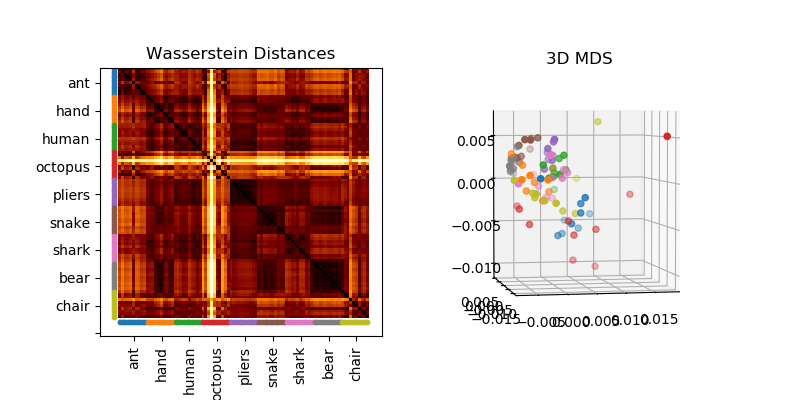

In [10]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(DWassNonrigid, cmap = 'afmhot', interpolation = 'none')
ax1 = plt.gca()
plt.xticks(5+10*np.arange(10), classes, rotation='vertical')
plt.yticks(5+10*np.arange(10), classes)
plt.title("Wasserstein Distances")

ax2 = plt.subplot(122, projection='3d')
ax2.set_title("3D MDS")
for i in range(9):
    X = XWassNonrigid[i*10:(i+1)*10, :]
    ax2.scatter(X[:, 0], X[:, 1], X[:, 2])
    Is = (i*10 + np.arange(10)).tolist() + (-2*np.ones(10)).tolist()
    Js = (91*np.ones(10)).tolist() + (i*10 + np.arange(10)).tolist()
    ax1.scatter(Is, Js, 10)

plt.show()